# Convolutional Neural Network (CNN) Project
Raquel Colares Santos

## Phase 1 - CNN architecture and Training

## Objective

The dataset used on this project is the animal_10, which contains 10 classes for animal classification.
The classification has around 28K animal images and the 10 classes are dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

The objective of this project is to apply the CNN concepts learned creating 2 CNN's architecture, training and evaluating the model, and after analyse 2 models using transfer learning using the same conditions as the previous ones created.  

## Data Preprocessing

In [1]:
# Installing the split-folders
!pip install split-folders

In [2]:
# Libraries
import torch
from torch import nn
import zipfile
from pathlib import Path
import splitfolders
import numpy as np
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import matplotlib.pyplot as plt

####   Setting the Device

On this project it will be used the GPU "cuda" for making the CNN more efficient since it has intensive computations.

In [3]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

####   Getting the data


The data was saved on my google drive, and connected to this jupyter, but in a zip format. This code was used to unzip the files that contains the images of the animals that will be used in the CNN.

In [4]:
# Setting the image path
data_path = Path("Project_CNN/")
image_path = data_path / "Images"

# Unziping the file
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Project_CNN/Images/animal_10.zip", "r") as zip_ref:
    print("Unzipping animals...")
    zip_ref.extractall(image_path)

Unzipping animals...


#### Translating the folders' name

The folders name are in other language, so the first thing to is to do is to translate the folders to English.

In [5]:
# Translating the folders
translate_path = Path("/content/Project_CNN/Images/translate.py")
f = open(translate_path, "r")
folder_dict = f.readline()
f.close()
exec(folder_dict)

os.chdir("/content/Project_CNN/Images/raw-img")
all_subdirs = []
for d in os.listdir("."):
    if os.path.isdir(d):
        all_subdirs.append(d)

for dir in all_subdirs:
  if dir in translate.keys():
    os.rename("/content/Project_CNN/Images/raw-img/" + dir, "/content/Project_CNN/Images/raw-img/" + translate.get(dir))

#### Splitting in Train and Test folders

In [6]:
# Splitting the folders in train and test
splitfolders.ratio("/content/Project_CNN/Images/raw-img", output="/content/Project_CNN/Images/animal_10", seed=42, ratio=(0.8, 0.0, 0.2)) # train, validation, test

Copying files: 26179 files [00:05, 4465.31 files/s]


#### Data Augmentation and Normalization

The transform prepares the raw image data to be compatible with the model. On this part I used the `transform.Normalize` to Normalize  the pixel values of an image, centering and scaling the data. And it was also used the `transforms.TrivialAugmentWide` as an augmentation technique (regularization to avoid overfitting), that is a simple strategy which randomly selects an augmentation.

In [7]:
# Train data (with augmentation and normalization)
train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test data
test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Creating the dataloader

In [8]:
train_dir = "/content/Project_CNN/Images/animal_10/train"
test_dir = "/content/Project_CNN/Images/animal_10/test"

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Setting the batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Creating the DataLoader's
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dfa6fadd5a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dfa6faddf00>)

##  CNN  models

### AlexNet

The architecture of the AlexNet consists of total 8 layers, which five are convolutional layers, followed by three fully-connected layers and a softmax at the end.
On first, second and fifth convolutional layers, have a max pooling layer, with stride of 2 and kernel size 3. It refers to the paper "ImageNet Classification with Deep Convolutional Neural Networks" that can be seen on the references of this project.

The AlexNet architecture was chosen to be used on this project because it's simple, effective, it is available for the transfer learning part, and it is a good fit for the size of my dataset.

**Observation:** Even the image of the paper showing 224x224 on the input, it was actually trained with 227x227

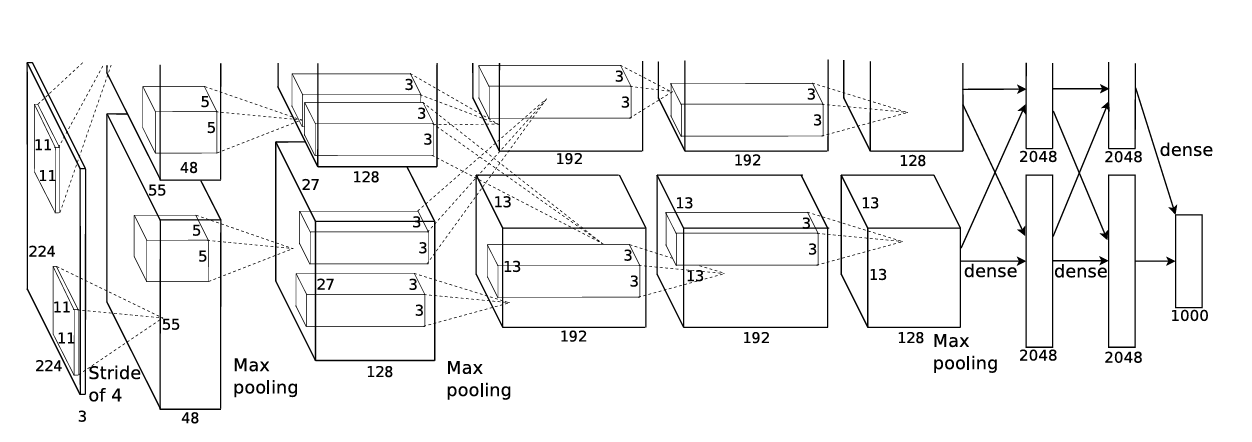

In [9]:
# Creating the AlexNet Class
class AlexNet(nn.Module):
    """
    Creation of the class for the AlexNet architecture
    """
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layer = nn.Sequential(
            ## 1st Convolutional Layer
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            ## 2nd Convolutional Layer
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            ## 3rd Convolutional Layer
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            ## 4th Convolutional Layer
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            ## 5th Convolutional Layer
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.fc_layer = nn.Sequential(
            ## 1st Fully connected layer
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            ## 2nd Fully connected layer
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            ## 3nd Fully connected layer
            nn.Linear(4096, num_classes))

    def forward(self, x):
        ## convolutional layers
        x = self.conv_layer(x)
        ## flatten
        x = x.reshape(x.size(0), -1)
        ## fully connected layers
        x = self.fc_layer(x)
        return x

In [10]:
NUM_CLASSES = 10
LEARNING_RATE = 0.001

# Setting the model with the parameters
model_1 = AlexNet(NUM_CLASSES).to(device)

# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum=0.9)

* Training and evaluating the model

In [11]:
TOTAL_STEP = len(train_dataloader)
NUM_EPOCHS = 20

# Setting the seed
torch.manual_seed(42)
# Starting the timer
start_time = timer()

# Creating lists for putting the tensor value in a list format to plot later
train_loss_plot = []
test_loss_plot = []
train_acc_plot = []
test_acc_plot = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_1.train()
        X = X.to(device)
        y = y.to(device)
        ## Forward pass
        y_pred = model_1(X)
        ## Calculating the loss
        loss = criterion(y_pred, y)
        train_loss += loss
        ## Optimizer zero grad
        optimizer.zero_grad()
        ## Backward
        loss.backward()
        ## Optimizer
        optimizer.step()
        ## Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    ## Adjusting metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # Testing
    test_loss = 0
    test_acc = 0
    model_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            ## Forward pass
            test_pred = model_1(X)
            ## Calculating the loss
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch
            ## Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    ## Adjusting metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} |  Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")
    train_loss_plot.append(train_loss.item())
    test_loss_plot.append(test_loss.item())
    train_acc_plot.append(train_acc)
    test_acc_plot.append(test_acc)

# Ending the timer
end_time = timer()
# Printing the total time
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.89210 |  Train acc: 0.33 | Test loss: 1.55688 | Test acc: 0.46

Epoch: 1 | Train loss: 1.53268 |  Train acc: 0.47 | Test loss: 1.20814 | Test acc: 0.57

Epoch: 2 | Train loss: 1.36070 |  Train acc: 0.53 | Test loss: 1.11070 | Test acc: 0.62

Epoch: 3 | Train loss: 1.24844 |  Train acc: 0.57 | Test loss: 0.93769 | Test acc: 0.67

Epoch: 4 | Train loss: 1.16838 |  Train acc: 0.60 | Test loss: 0.97996 | Test acc: 0.67

Epoch: 5 | Train loss: 1.10138 |  Train acc: 0.62 | Test loss: 0.91414 | Test acc: 0.68

Epoch: 6 | Train loss: 1.04078 |  Train acc: 0.64 | Test loss: 1.00411 | Test acc: 0.66

Epoch: 7 | Train loss: 0.99064 |  Train acc: 0.66 | Test loss: 0.86523 | Test acc: 0.71

Epoch: 8 | Train loss: 0.93854 |  Train acc: 0.68 | Test loss: 0.82862 | Test acc: 0.72

Epoch: 9 | Train loss: 0.91178 |  Train acc: 0.69 | Test loss: 0.72753 | Test acc: 0.75

Epoch: 10 | Train loss: 0.87354 |  Train acc: 0.70 | Test loss: 0.71487 | Test acc: 0.76

Epoch: 11 | Train lo

* Plotting the Loss curve

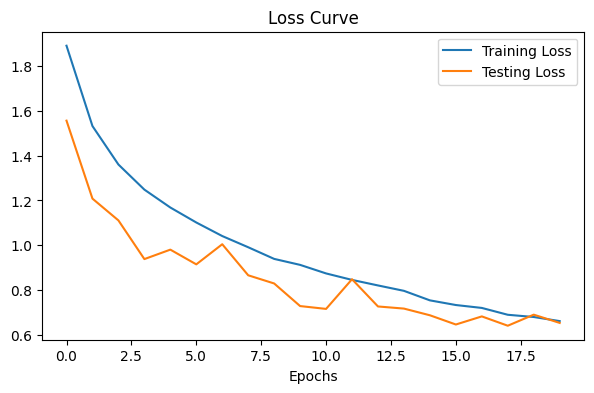

In [12]:
# Plotting the Loss Curve
epochs_train_loss = range(len(train_loss_plot))
epochs_test_loss = range(len(test_loss_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_loss, train_loss_plot, label="Training Loss")
plt.plot(epochs_test_loss, test_loss_plot, label="Testing Loss")
plt.xlabel("Epochs")
plt.title("Loss Curve")
plt.legend()
plt.show();

* Plotting the Accuracy

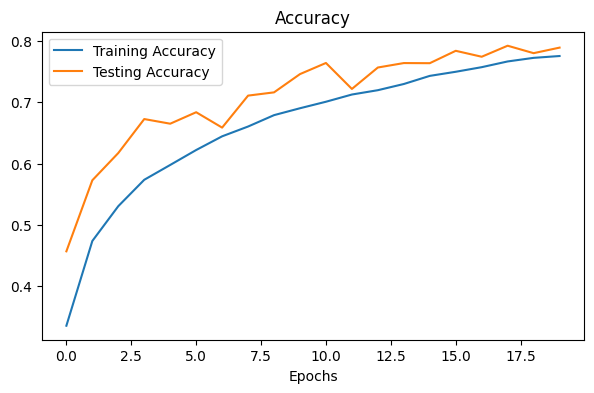

In [13]:
# Plotting the Accuracy
epochs_train_acc = range(len(train_acc_plot))
epochs_test_acc = range(len(test_acc_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_acc, train_acc_plot, label="Training Accuracy")
plt.plot(epochs_test_acc, test_acc_plot, label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

* Analysing the model AlexNet

For training the model, I tried different hyperparameters, with and without momentum, with and without weight decay, with different learning rates and also with different epochs. After, fine tuning the model for 20 epochs, I got 78% accuracy for training and 79% accuracy for testing. Analysing the values obtained for accuracy, loss, and the plottings above, we can see that the AlexNet model is learning, the loss is decreasing consistent, it has good accuracy and the training is closer to the testing, so my model is not overfitting.   

* Saving the model

In [14]:
torch.save(model_1.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Project_CNN/Models/AlexNet.pth")

### VGG16

The architecture of the VGG16 consists of sixteen layers total, which thirteen are convolutional layers, followed by three fully connected layers. Between the second, fourth, seventh, tenth, and thirteen layer, it has a max pooling layer for downsampling. It refers to the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" that can be seen on the references of this project.

The VGG16 architecture was chosen to be used on this project because it's effective, it is available for the transfer learning part, it's a deep architecture which means that it can captures more features, as a trade-off, I am aware it takes more time and it's more computational expensive if compared with the last model.


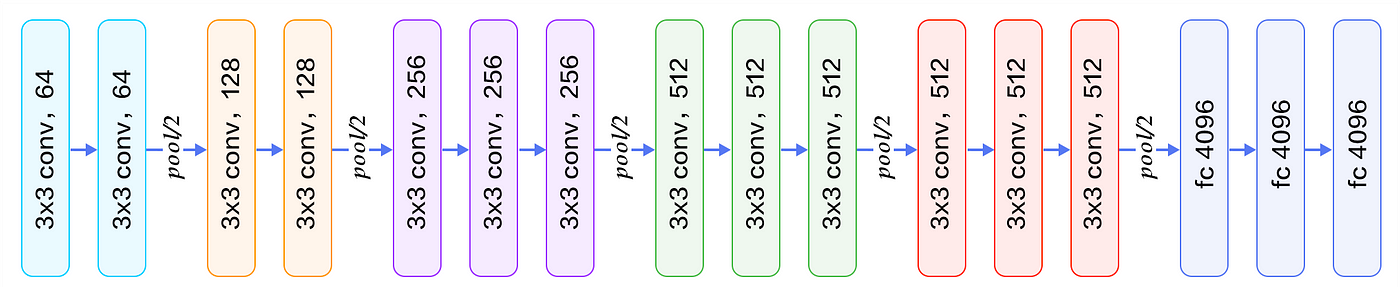

In [15]:
# Creating the VGG16 Class
class VGG16(nn.Module):
    """
    Creation of the class for the  VGG16 architecture
    """
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layer = nn.Sequential(
            ## 1st Convolutional Layer
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ## 2nd Convolutional Layer
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            ## 3rd Convolutional Layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ## 4th Convolutional Layer
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            ## 5th Convolutional Layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ## 6th Convolutional Layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ## 7th Convolutional Layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            ## 8th Convolutional Layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ## 9th Convolutional Layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ## 10th Convolutional Layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            ## 11th Convolutional Layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ## 12th Convolutional Layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ## 13th Convolutional Layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc_layer = nn.Sequential(
            ## 1st Fully connected layer
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            ## 2nd Fully connected layer
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            ## 3rd Fully connected layer
            nn.Linear(4096, num_classes))

    def forward(self, x):
        ## convolutional layers
        x = self.conv_layer(x)
        ## flatten
        x = x.reshape(x.size(0), -1)
        ## fully connected layers
        x = self.fc_layer(x)
        return x


In [16]:
NUM_CLASSES = 10
LEARNING_RATE = 0.001

# Setting the model with the parameters
model_2 = VGG16(NUM_CLASSES).to(device)

# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_2.parameters(), lr=LEARNING_RATE,  weight_decay = 0.005, momentum=0.9)

* Training and evaluating the model

In [17]:
TOTAL_STEP = len(train_dataloader)
NUM_EPOCHS = 20

# Setting the seed
torch.manual_seed(42)
# Starting the timer
start_time = timer()

# Creating lists for putting the tensor value in a list format to plot later
train_loss_plot = []
test_loss_plot = []
train_acc_plot = []
test_acc_plot = []

for epoch in range(NUM_EPOCHS):
    # Training
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_2.train()
        X = X.to(device)
        y = y.to(device)
        ## Forward pass
        y_pred = model_2(X)
        ## Calculating the loss
        loss = criterion(y_pred, y)
        train_loss += loss
        ## Optimizer zero grad
        optimizer.zero_grad()
        ## Backward
        loss.backward()
        ## Optimizer
        optimizer.step()
        ## Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    ## Adjusting metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # Testing
    test_loss = 0
    test_acc = 0
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            ## Forward pass
            test_pred = model_2(X)
            ## Calculating the loss
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch
            ## Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    ## Adjusting metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} |  Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")
    train_loss_plot.append(train_loss.item())
    test_loss_plot.append(test_loss.item())
    train_acc_plot.append(train_acc)
    test_acc_plot.append(test_acc)

# Ending the timer
end_time = timer()
# Printing the total time
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.84775 |  Train acc: 0.35 | Test loss: 1.35734 | Test acc: 0.54

Epoch: 1 | Train loss: 1.46929 |  Train acc: 0.49 | Test loss: 1.20068 | Test acc: 0.59

Epoch: 2 | Train loss: 1.28585 |  Train acc: 0.55 | Test loss: 1.06555 | Test acc: 0.63

Epoch: 3 | Train loss: 1.13890 |  Train acc: 0.61 | Test loss: 0.92342 | Test acc: 0.68

Epoch: 4 | Train loss: 1.03035 |  Train acc: 0.65 | Test loss: 0.84506 | Test acc: 0.70

Epoch: 5 | Train loss: 0.93905 |  Train acc: 0.68 | Test loss: 0.73834 | Test acc: 0.75

Epoch: 6 | Train loss: 0.85610 |  Train acc: 0.71 | Test loss: 0.89283 | Test acc: 0.72

Epoch: 7 | Train loss: 0.79653 |  Train acc: 0.73 | Test loss: 0.73811 | Test acc: 0.76

Epoch: 8 | Train loss: 0.73073 |  Train acc: 0.76 | Test loss: 0.73193 | Test acc: 0.75

Epoch: 9 | Train loss: 0.68525 |  Train acc: 0.77 | Test loss: 0.60010 | Test acc: 0.80

Epoch: 10 | Train loss: 0.64159 |  Train acc: 0.78 | Test loss: 0.59688 | Test acc: 0.80

Epoch: 11 | Train lo

* Plotting the Loss curve

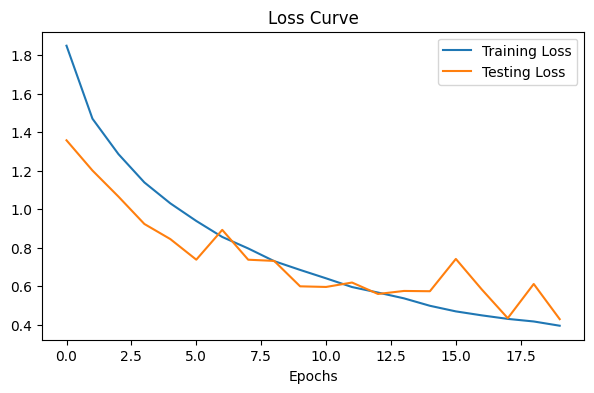

In [18]:
# Ploting the Loss Curve
epochs_train = range(len(train_loss_plot))
epochs_test = range(len(test_loss_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train, train_loss_plot, label='Training Loss')
plt.plot(epochs_test, test_loss_plot, label='Testing Loss')
plt.xlabel('Epochs')
plt.title('Loss Curve')
plt.legend()
plt.show();

* Plotting the Accuracy

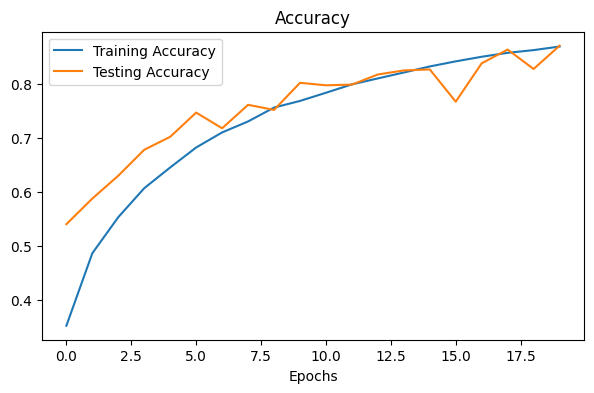

In [19]:
# Plotting the Accuracy
epochs_train_acc = range(len(train_acc_plot))
epochs_test_acc = range(len(test_acc_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_acc, train_acc_plot, label="Training Accuracy")
plt.plot(epochs_test_acc, test_acc_plot, label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

* Analysing the model VGG16

For training the model, I tried different hyperparameters, with and without momentum, with and without weight decay, with different learning rates and also with different epochs. After, fine tuning the model for 20 epochs, I got 87% accuracy for training and 87% accuracy for testing. Analysing the values obtained for accuracy, loss, and the plottings above, we can see that the VGG16 model is learning, the loss is decreasing consistent, it has good accuracy and the training is closer to the testing, so my model is not overfitting. The VGG16 performed better than the AlexNet.

* Saving the model

In [20]:
torch.save(model_2.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Project_CNN/Models/VGG16.pth")

## References

https://pytorch.org/vision/stable/transforms.html

https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

https://pytorch.org/vision/stable/models.html#classification

https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html

https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html

https://arxiv.org/abs/1409.1556